<a href="https://colab.research.google.com/github/Aggraj/Deep-Learning-CS-6910/blob/main/tSNE_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import WandB 

In [6]:
!pip install wandb
import wandb


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.manifold import TSNE

**Read the Fashion MNIST data set, divide the data set as train and validation. There are 10 class in the data set. Initialize all the variables e.g : number of hidden layer size, number of class etc**

In [8]:
# load the Fashion MNIST data set
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

Project='ASSIGNMENT 4'


# Split the data set and assign the data values depending on thresholding
X_train = np.array(x_train.reshape(x_train.shape[0], 784,1))         
X_test  = np.array(x_test.reshape(x_test.shape[0], 784,1))           
X_train = (X_train > 126) * 1                                        
X_test  = (X_test > 126) * 1                                         
X_val = X_train[-15000:]                                             
X_train = X_train[0:45000]                                           

Y_train = np.zeros([len(y_train),10,1])
Y_test = np.zeros([len(y_test),10,1])

for i in range(len(y_train)):                                       
  y = np.zeros([10, 1])
  y[y_train[i]] = 1.0
  Y_train[i] = y

for i in range(len(y_test)):                                         
  y = np.zeros([10, 1])
  y[y_test[i]] = 1.0
  Y_test[i] = y                                                      

Y_val = Y_train[-15000:]                                             
Y_train = Y_train[0:45000]        


n_vis = X_train.shape[1]                                         
n_train = X_train.shape[0]                                  
n_val = X_val.shape[0]                                      
n_test = X_test.shape[0]                                    
n_hidden = 64                 
n_class = 10


**Define activation functions, Initalize Parameters**

In [9]:

def sigmoid(x) :                                                                              
	
  return 1.0/(1.0+np.exp(-x))

def softmax(x):                                                                               
  return np.exp(x) / np.sum(np.exp(x))  
  
def hidden_r(n,W,image,c):
  return np.random.binomial(1,sigmoid(np.dot(W,image)+c))

def RBM_init_params() :                                                                        
	
  RBM_params = {}
  RBM_params["W"] = np.random.randn(n_hidden, n_vis)*np.sqrt(6./(n_vis + n_hidden))   
  RBM_params["h_b"] = np.zeros((n_hidden,1),dtype=np.float64)                                                     
  RBM_params["v_b"] = np.zeros((n_vis,1),dtype=np.float64)

  return RBM_params

def Class_params_init() :                                                                 

  class_params = {}
  class_params["W"] = np.random.randn(n_class, n_hidden)*np.sqrt(6./(n_class + n_hidden))       
  class_params["b"] = np.zeros((n_class,1),dtype=np.float64)

  return class_params


def hidden_representation(x,parameters) :                                                               
   
    W = parameters["W"]
    h_b = parameters["h_b"]
    hidden_prob = sigmoid(np.dot(W,x)+h_b)
    hidden_rep = np.random.binomial(1,hidden_prob)
    
    return hidden_rep                                   

# **Train the RBM model using Gibbs sampling and Train the classifer**

In [10]:
def Train_RBM(X_train,parameters,k,learning_rate) :                       # Function to train the RBM
	
  W = parameters["W"]
  h_b = parameters["h_b"]
  v_b = parameters["v_b"]
  
  
  for i in range(n_train) :
      v_s = X_train[i]
      v_in   = X_train[i]

      for t in range(k) :                                                               # Markov Chain 
         p_h_g_v = sigmoid(np.dot(W,v_s)+h_b)                                  
         h_s = np.random.binomial(1,p_h_g_v)                                      
         p_v_g_h = sigmoid(np.dot(np.transpose(W),h_s)+v_b)                    
         v_s = np.random.binomial(1,p_v_g_h)                                      # Convert to 0's and 1's using binomial distribution 

      # Update Rule
      W = W + learning_rate*(np.dot(sigmoid(np.dot(W,v_in)+h_b),np.transpose(v_in)) - np.dot(sigmoid(np.dot(W,v_s)+h_b),np.transpose(v_s)))
      v_b = v_b + learning_rate*(v_in-v_s)
      h_b = h_b + learning_rate*(sigmoid(np.dot(W,v_in)+h_b) - sigmoid(np.dot(W,v_s)+h_b))

  parameters["W"] = W
  parameters["h_b"] = h_b
  parameters["v_b"] = v_b

  return parameters



(10000, 2)


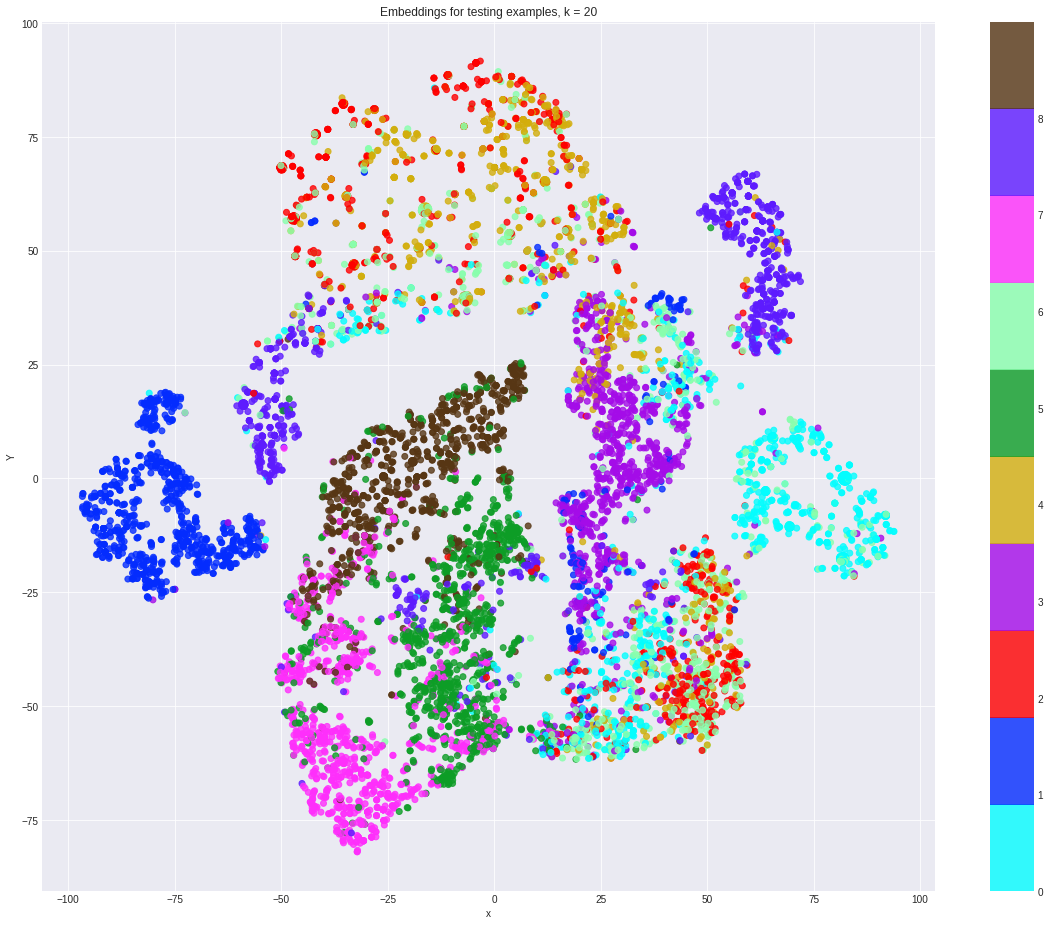

In [11]:
RBM_params = RBM_init_params()
RBM_params = Train_RBM(X_train,RBM_params,15,0.005)
W = RBM_params["W"]
c = RBM_params["h_b"]

k = 20
num_test = np.shape(X_test)[0]
hidden_repsentation = []
for i in range(num_test):                                         
  Test_image = X_test[i,:]
  h = hidden_r(64, W, Test_image, c)
  hidden_repsentation.append(np.array(h[:,0]))

hidden_repsentation = np.array(hidden_repsentation)
Tsne_op = TSNE(n_components = 2, early_exaggeration = 7).fit_transform(hidden_repsentation)
print(np.shape(Tsne_op))

# path_pickle = join(path_folder, "Tsne_op.pickle")

x_cord = Tsne_op[:,0]
y_cord = Tsne_op[:,1]

#print(np.shape(labels_test))
colors = ['#04FEFF','#042CFF','#FF0000','#A40CE8','#D3AE0D','#0D9D26','#89FFAD','#FF2FFC','#5D1BFF','#573614']
style = 'seaborn-darkgrid'
plt.style.use(style)
plt.figure(figsize = (20,16))
plt.title("Embeddings for testing examples, k = " + str(k))
plt.xlabel("x")
plt.ylabel("Y")
plt.scatter(x_cord[:10000], y_cord[:10000], c = y_test[:10000],cmap=matplotlib.colors.ListedColormap(colors),alpha=0.8)
plt.colorbar(ticks = range(max(y_test)))

plt.show()
